In [ ]:
import numpy as np 
import pandas as pd 
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        os.path.join(dirname, filename)

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from collections import Counter
import numpy as np
import os
import shutil
from sklearn.utils import resample
from keras.preprocessing.image import load_img, img_to_array, save_img
from keras.utils import image_dataset_from_directory
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

In [45]:
dataset_path = "/Users/abhishek_ks/Desktop/Python project/dataset/dataset_blood_group"

In [46]:
BATCH_SIZE = 32

In [ ]:
# Load dataset
dataset = image_dataset_from_directory(
    dataset_path,
    labels="inferred",
    label_mode="int",
    image_size=(128, 128),
    batch_size=BATCH_SIZE,
    shuffle=True
)

Found 6000 files belonging to 8 classes.


In [ ]:
from collections import Counter

#Check class distribution
class_names = dataset.class_names
class_counts = Counter()

for image, labels in dataset.unbatch():
    class_counts[int(labels.numpy())] += 1

print("Class Distribution:")
for i, count in class_counts.items():
    print(f"{class_names[i]}: {count}") 


Class Distribution:
O+: 852
O-: 712
A-: 1009
B+: 652
B-: 741
A+: 565
AB+: 708
AB-: 761


Class Distribution:
O+: 852
A-: 1009
A+: 565
O-: 712
B-: 741
B+: 652
AB+: 708
AB-: 761


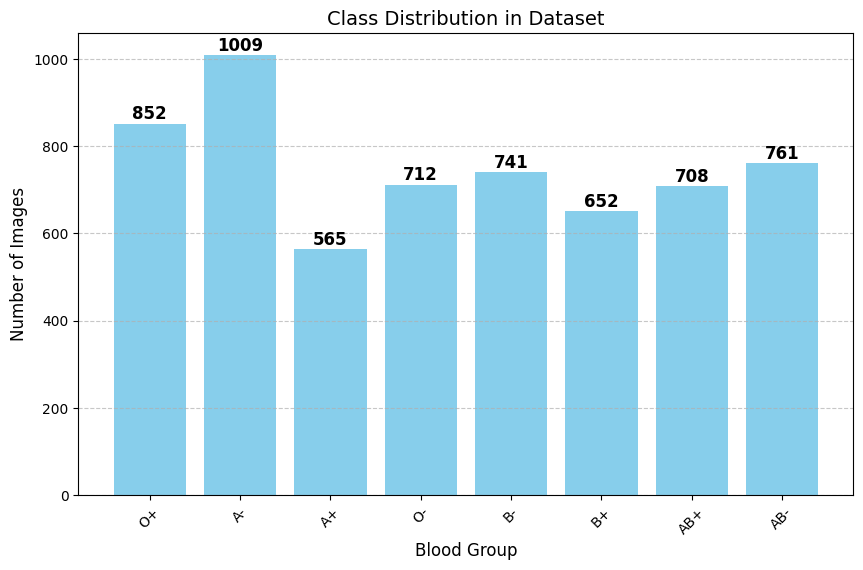

In [ ]:
from collections import Counter
import matplotlib.pyplot as plt

# Step 2: Check class distribution
class_names = dataset.class_names 
class_counts = Counter()

for image, labels in dataset.unbatch():
    class_counts[int(labels.numpy())] += 1 

class_counts_dict = {class_names[i]: count for i, count in class_counts.items()}

print("Class Distribution:")
for blood_group, count in class_counts_dict.items():
    print(f"{blood_group}: {count}")

def plot_class_distribution(class_counts_dict):
    """
    Plots the distribution of blood group classes in the dataset with numbers on top of bars.
    """
    plt.figure(figsize=(10, 6))

    classes = list(class_counts_dict.keys())
    counts = list(class_counts_dict.values())

    bars = plt.bar(classes, counts, color='skyblue')

    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, height + 10, str(height), ha='center', fontsize=12, fontweight='bold')

    plt.xlabel("Blood Group", fontsize=12)
    plt.ylabel("Number of Images", fontsize=12)
    plt.title("Class Distribution in Dataset", fontsize=14)
    plt.xticks(rotation=45)
    plt.grid(axis="y", linestyle="--", alpha=0.7) 
    plt.show()

plot_class_distribution(class_counts_dict)


In [50]:
max_count = max(class_counts.values())

In [ ]:
import tensorflow as tf

# Function to oversample a class
def oversample_class(class_id, count, max_count, dataset):
    """
    Oversamples a specific class to match the max_count.

    Parameters:
    - class_id (int): The class index to oversample.
    - count (int): The current number of samples for this class.
    - max_count (int): The target count for balancing.
    - dataset (tf.data.Dataset): The original dataset.

    Returns:
    - tf.data.Dataset: Oversampled dataset for the specified class.
    """

    unbatched_dataset = dataset.unbatch()

    class_dataset = unbatched_dataset.filter(lambda img, lbl: tf.equal(lbl, class_id))

    repeat_factor = max_count // count + int(max_count % count > 0)  

    return class_dataset.repeat(repeat_factor).take(max_count)

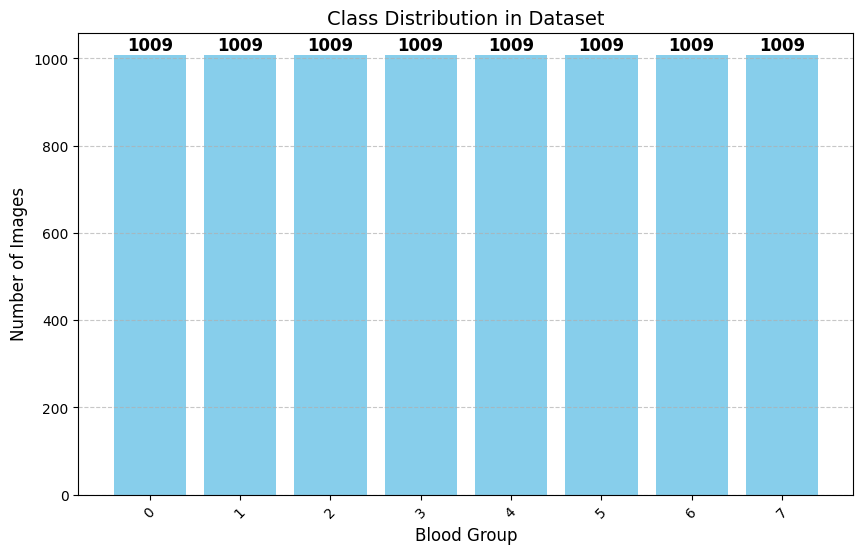

In [ ]:
# Fix function definition (dataset comes first)
def oversample_class(dataset, class_id, count, max_count):
    unbatched_dataset = dataset.unbatch()

    class_dataset = unbatched_dataset.filter(lambda img, lbl: tf.equal(lbl, class_id))

    repeat_factor = max_count // count + (1 if max_count % count > 0 else 0)

    return class_dataset.repeat(repeat_factor).take(max_count)

balanced_datasets = []
for class_id, count in class_counts.items():
    balanced_datasets.append(oversample_class(dataset, class_id, count, max_count))  # ✅ Correct order

balanced_dataset = tf.data.Dataset.sample_from_datasets(balanced_datasets)

balanced_class_counts = Counter()

for _, lbl in balanced_dataset:
    balanced_class_counts[int(lbl.numpy())] += 1

plot_class_distribution(balanced_class_counts)

BATCH_SIZE = 32  
balanced_dataset = balanced_dataset.batch(BATCH_SIZE, drop_remainder=True)


In [53]:
for sample in balanced_dataset. take (10):
  print(sample[0] .shape)

(32, 64, 64, 3)
(32, 64, 64, 3)
(32, 64, 64, 3)
(32, 64, 64, 3)
(32, 64, 64, 3)
(32, 64, 64, 3)
(32, 64, 64, 3)
(32, 64, 64, 3)
(32, 64, 64, 3)
(32, 64, 64, 3)


In [ ]:
balanced_dataset_unbatched = balanced_dataset.unbatch()  
dataset_size = sum(1 for _ in balanced_dataset_unbatched)
print(f"Total dataset size: {dataset_size}")

Total dataset size: 8064


In [ ]:
# Define dataset split ratios
train_ratio = 0.7  
val_ratio = 0.15   
test_ratio = 0.15  

balanced_dataset_unbatched = balanced_dataset.unbatch() 

dataset_size = sum(1 for _ in balanced_dataset_unbatched) 

train_size = int(train_ratio * dataset_size)
val_size = int(val_ratio * dataset_size)

train_dataset = balanced_dataset_unbatched.take(train_size) 
val_test_dataset = balanced_dataset_unbatched.skip(train_size)  

val_dataset = val_test_dataset.take(val_size)  
test_dataset = val_test_dataset.skip(val_size)  

train_dataset = train_dataset.batch(BATCH_SIZE, drop_remainder=True)
val_dataset = val_dataset.batch(BATCH_SIZE, drop_remainder=True)
test_dataset = test_dataset.batch(BATCH_SIZE, drop_remainder=True)

# Check the number of batches in each dataset
train_batch_count = sum(1 for _ in train_dataset) 
val_batch_count = sum(1 for _ in val_dataset)  
test_batch_count = sum(1 for _ in test_dataset)  
print(f"Training dataset size: {train_batch_count * BATCH_SIZE}")
print(f"Validation dataset size: {val_batch_count * BATCH_SIZE}")
print(f"Testing dataset size: {test_batch_count * BATCH_SIZE}")

Training dataset size: 5632
Validation dataset size: 1184
Testing dataset size: 1184


In [ ]:
import tensorflow as tf

def create_high_accuracy_model(class_names):
    model = tf.keras.models.Sequential([
        tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(64, 64, 3)),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Dropout(0.3),

        tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Dropout(0.4),

        tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Dropout(0.4),

        tf.keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Dropout(0.4),

        tf.keras.layers.Conv2D(512, (3, 3), activation='relu', padding='same'),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Dropout(0.5),

        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(1024, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(len(class_names), activation='softmax')  
    ])

    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    return model

high_acc_model = create_high_accuracy_model(class_names)

high_acc_model.summary()

/Users/abhishek_ks/Desktop/Python project/venv/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_10 (Conv2D)              │ (None, 64, 64, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 32, 32, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 16, 16, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 8, 8, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 4, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 4, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 4, 4, 512)      │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (None, 2, 2, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 2, 2, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1024)           │     2,098,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 8)              │         8,200 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,674,952 (14.02 MB)

 Trainable params: 3,674,952 (14.02 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',    
    factor=0.5,            
    patience=3,            
    verbose=1,             
    min_lr=1e-6            
)

early_stop = EarlyStopping(
    monitor='val_loss',   
    patience=5,            
    verbose=1,             
    restore_best_weights=True  
)


In [ ]:
# Train the model
history_high_acc = high_acc_model.fit(
    train_dataset,                   
    validation_data=val_dataset,      
    epochs=25,                       
    callbacks=[reduce_lr, early_stop] 
)

Epoch 1/25
    176/Unknown 30s 161ms/step - accuracy: 0.1341 - loss: 32.6971

/Users/abhishek_ks/Desktop/Python project/venv/lib/python3.9/site-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


176/176 ━━━━━━━━━━━━━━━━━━━━ 34s 182ms/step - accuracy: 0.1341 - loss: 32.5616 - val_accuracy: 0.1217 - val_loss: 2.0244 - learning_rate: 0.0010
Epoch 2/25
176/176 ━━━━━━━━━━━━━━━━━━━━ 27s 153ms/step - accuracy: 0.1602 - loss: 2.0622 - val_accuracy: 0.1398 - val_loss: 2.0245 - learning_rate: 0.0010
Epoch 3/25


2025-04-19 20:46:42.737996: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


176/176 ━━━━━━━━━━━━━━━━━━━━ 22s 125ms/step - accuracy: 0.3750 - loss: 1.6097 - val_accuracy: 0.5025 - val_loss: 1.5233 - learning_rate: 0.0010
Epoch 4/25
176/176 ━━━━━━━━━━━━━━━━━━━━ 23s 128ms/step - accuracy: 0.5727 - loss: 1.1607 - val_accuracy: 0.5444 - val_loss: 1.3070 - learning_rate: 0.0010
Epoch 5/25
176/176 ━━━━━━━━━━━━━━━━━━━━ 22s 127ms/step - accuracy: 0.6429 - loss: 0.9724 - val_accuracy: 0.6760 - val_loss: 1.0991 - learning_rate: 0.0010
Epoch 6/25
176/176 ━━━━━━━━━━━━━━━━━━━━ 22s 126ms/step - accuracy: 0.6762 - loss: 0.8975 - val_accuracy: 0.5173 - val_loss: 1.2011 - learning_rate: 0.0010
Epoch 7/25
176/176 ━━━━━━━━━━━━━━━━━━━━ 23s 128ms/step - accuracy: 0.6947 - loss: 0.8295 - val_accuracy: 0.8174 - val_loss: 0.8229 - learning_rate: 0.0010
Epoch 8/25
176/176 ━━━━━━━━━━━━━━━━━━━━ 22s 125ms/step - accuracy: 0.7448 - loss: 0.7253 - val_accuracy: 0.7278 - val_loss: 0.9070 - learning_rate: 0.0010
Epoch 9/25
176/176 ━━━━━━━━━━━━━━━━━━━━ 23s 129ms/step - accuracy: 0.7632 - loss:

In [ ]:
# Evaluate the model 
high_acc_eval = high_acc_model.evaluate(val_dataset)

print(f"High Accuracy Model - Loss: {high_acc_eval[0]}, Accuracy: {high_acc_eval[1]}")

37/37 ━━━━━━━━━━━━━━━━━━━━ 5s 60ms/step - accuracy: 0.8950 - loss: 0.4236
High Accuracy Model - Loss: 0.41777023673057556, Accuracy: 0.8667762875556946


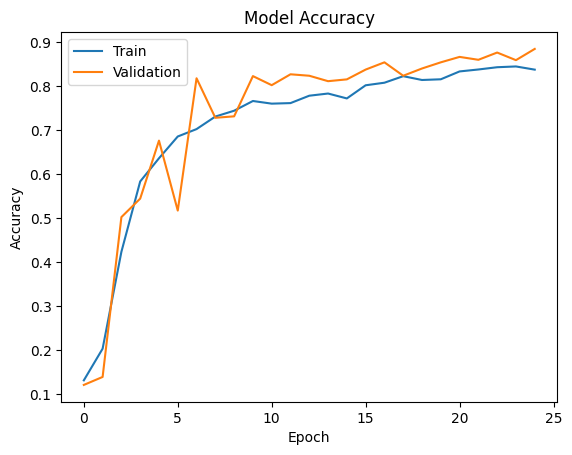

In [ ]:
import matplotlib.pyplot as plt

#plot training & validation accuracy
def plot_accuracy(history):
    plt.plot(history.history['accuracy'])  
    plt.plot(history.history['val_accuracy'])  
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()  
    
plot_accuracy(history_high_acc)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━

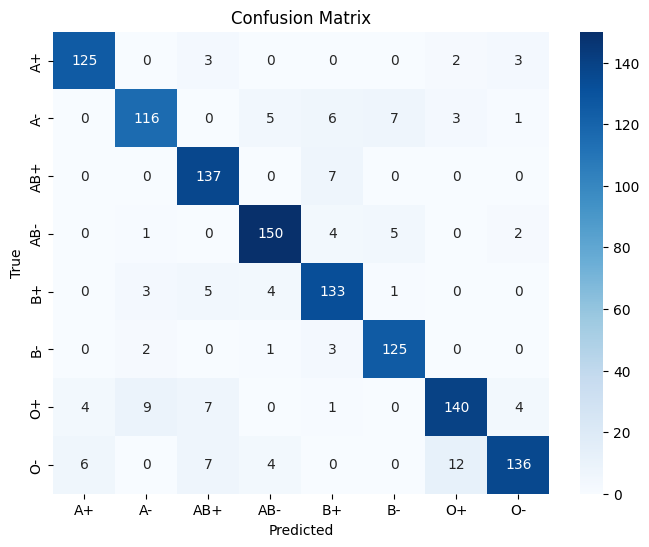

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

y_true = []  
y_pred = []  

for images, labels in test_dataset:
    predictions = high_acc_model.predict(images)  
    predicted_labels = np.argmax(predictions, axis=1)  
    y_true.extend(labels.numpy())  
    y_pred.extend(predicted_labels)  

y_true = np.array(y_true)
y_pred = np.array(y_pred)

report = classification_report(y_true, y_pred, target_names=class_names)
print("Classification Report:")
print(report)

# Confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [ ]:
high_acc_model.save('model.h5') 
print("Model saved as HDF5 format.")

Model saved as HDF5 format.


In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, classification_report

# Calculate Accuracy
accuracy = accuracy_score(y_true, y_pred)
print(f"Accuracy: {accuracy:.4f}")

precision_macro = precision_score(y_true, y_pred, average='macro')
precision_micro = precision_score(y_true, y_pred, average='micro')
precision_weighted = precision_score(y_true, y_pred, average='weighted')

print(f"Precision (Macro): {precision_macro:.4f}")
print(f"Precision (Micro): {precision_micro:.4f}")
print(f"Precision (Weighted): {precision_weighted:.4f}")

recall_macro = recall_score(y_true, y_pred, average='macro')
recall_micro = recall_score(y_true, y_pred, average='micro')
recall_weighted = recall_score(y_true, y_pred, average='weighted')

print(f"Recall (Macro): {recall_macro:.4f}")
print(f"Recall (Micro): {recall_micro:.4f}")
print(f"Recall (Weighted): {recall_weighted:.4f}")

f1_macro = f1_score(y_true, y_pred, average='macro')
f1_micro = f1_score(y_true, y_pred, average='micro')
f1_weighted = f1_score(y_true, y_pred, average='weighted')

print(f"F1 Score (Macro): {f1_macro:.4f}")
print(f"F1 Score (Micro): {f1_micro:.4f}")
print(f"F1 Score (Weighted): {f1_weighted:.4f}")

print("\nFull Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))


Accuracy: 0.8970
Precision (Macro): 0.8975
Precision (Micro): 0.8970
Precision (Weighted): 0.8980
Recall (Macro): 0.8995
Recall (Micro): 0.8970
Recall (Weighted): 0.8970
F1 Score (Macro): 0.8975
F1 Score (Micro): 0.8970
F1 Score (Weighted): 0.8964

Full Classification Report:
              precision    recall  f1-score   support

          A+       0.93      0.94      0.93       133
          A-       0.89      0.84      0.86       138
         AB+       0.86      0.95      0.90       144
         AB-       0.91      0.93      0.92       162
          B+       0.86      0.91      0.89       146
          B-       0.91      0.95      0.93       131
          O+       0.89      0.85      0.87       165
          O-       0.93      0.82      0.87       165

    accuracy                           0.90      1184
   macro avg       0.90      0.90      0.90      1184
weighted avg       0.90      0.90      0.90      1184

